In [10]:
import pandas as pd
import matplotlib.pyplot as plt


import logging
import time
from pathlib import Path
import tqdm
from typing import Dict

import torch
from transformers import AutoTokenizer, AutoModel
from torch.nn import functional as F
from sklearn.metrics import classification_report, ConfusionMatrixDisplay

# internal libraries
from ressources import target_to_label, raw_target

# set a seed value
torch.manual_seed(555)

log = logging.getLogger(__name__)
log.setLevel(logging.WARNING)

In [11]:
results_dir = Path("results")
results_dir.mkdir(exist_ok=True)
now = time.time()

target2label = target_to_label

label_to_target = {v: k for k, v in target2label.items()}

with open(results_dir / Path(f"zs-latent-embedding-{now}.csv"), "w") as f:
    f.write(
        "text,target1,target2,exec_time,"
        + ",".join([k for k in target2label.keys()])
        + "\n"
    )

labels = list(v for v in target2label.values())

targets = list(target2label.keys())
targets.append("0")
print(f"Targets -- {targets}")

Targets -- ['12.1', '12.2', '12.3', '12.4', '12.5', '12.6', '12.7', '12.8', '12.a', '12.b', '12.c', '15.1', '15.2', '15.3', '15.4', '15.5', '15.6', '15.7', '15.8', '15.9', '15.a', '15.b', '15.c', '16.1', '16.2', '16.3', '16.4', '16.5', '16.6', '16.7', '16.8', '16.9', '16.10', '16.a', '0']


In [12]:
df = pd.read_csv("data/afd_targets_odd_12_15_16.csv")
df.head()

,text,target1,target2
0,As mentioned earlier the respondents were sele...,0,0
1,6 domestic waste incineration 5 Rural habitat ...,0,0
2,i Pollutant discharge permit system All enterp...,15.1,0
3,significant conversion of natural should be av...,15.3,0
4,4Note Core Principle 2 Impacts on Natural Habi...,15.5,0


In [13]:
pbar = tqdm.tqdm(total=df.shape[0])

  8%|▊         | 12/150 [01:51<21:23,  9.30s/it]


In [14]:
tokenizer = AutoTokenizer.from_pretrained("deepset/sentence_bert")
model = AutoModel.from_pretrained("deepset/sentence_bert")

Some weights of the model checkpoint at deepset/sentence_bert were not used when initializing BertModel: ['classifier.weight', 'classifier.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [15]:
def predict(text):
    """
    Function to predict one text

    :param sentence: Text to predict
    """
    # run inputs through model and mean-pool over the sequence
    # dimension to get sequence-level representations
    inputs = tokenizer.batch_encode_plus(
        [text] + labels,
        truncation=True,
        padding=True,
        max_length=512,
        return_tensors="pt",
    )
    input_ids = inputs["input_ids"]
    attention_mask = inputs["attention_mask"]
    output = model(input_ids, attention_mask=attention_mask)[0]
    text_rep = output[:1].mean(dim=1)
    label_reps = output[1:].mean(dim=1)

    # now find the labels with the highest cosine similarities to
    # the sentence
    similarities = F.cosine_similarity(text_rep, label_reps)
    closest = similarities.argsort(descending=True)

    if log.level == logging.INFO:
        for ind in closest:
            log.debug(
                f"label: {labels[ind]} target: {label_to_target[labels[ind]]} \t similarity: {similarities[ind]:.2f}"
            )

    return closest, similarities

In [16]:
def export_results(text: str, target1, target2, results: Dict):
    """
    Function to export results to csv
    """
    with open(results_dir / Path(f"zs-latent-embedding-{now}.csv"), "a") as f:
        new_line = (
            f'"{text}",{target1},{target2},'
            + ",".join([f"{v:.2f}" for v in results.values()])
            + "\n"
        )
        f.write(new_line)

In [17]:
def calcul_score(closest, principal_target):
    """
    :param closest:
    :param principal target:
    """
    pass

In [18]:
y_true, y_pred = [], []

for _, row in df.iterrows():

    results = {**{"exec_time": 0}, **{k: 0 for k in target2label.keys()}}

    text = row["text"]
    principal_target = row["target1"]
    second_target = row["target2"]
    log.debug(text)

    start_time = time.time()

    # Run prediction
    closest, similarities = predict(text)

    total_time = time.time() - start_time
    results["exec_time"] = total_time

    for ind in closest:
        target = label_to_target[labels[ind]]
        results[target] = similarities[ind]

    y_true.append(principal_target)
    # target with the highest cost similarity
    y_pred.append(label_to_target[labels[closest[0]]])

    # calcul_score(closest, principal_target)

    log.debug(f"Total prediction time : {total_time:0.2f}s")
    log.debug(f"1st target : {principal_target} 2nd target : {second_target}")

    # export result to csv
    export_results(text, principal_target, second_target, results)
    del results

    pbar.update(1)

/Users/guillaume/hackathon-odd/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/guillaume/hackathon-odd/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/guillaume/hackathon-odd/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(res

              precision    recall  f1-score   support

        12.1       0.00      0.00      0.00         0
        12.2       0.00      0.00      0.00         1
        12.3       0.00      0.00      0.00         2
        12.4       0.45      0.37      0.41        27
        12.5       0.00      0.00      0.00        11
        12.6       0.00      0.00      0.00         0
        12.7       0.00      0.00      0.00         1
        12.8       0.00      0.00      0.00         0
        12.a       0.25      0.50      0.33         2
        12.b       0.00      0.00      0.00         0
        12.c       0.00      0.00      0.00         0
        15.1       0.43      0.60      0.50        15
        15.2       0.43      0.50      0.46         6
        15.3       0.00      0.00      0.00         4
        15.4       0.00      0.00      0.00         0
        15.5       0.00      0.00      0.00         7
        15.6       0.00      0.00      0.00         4
        15.7       0.00    

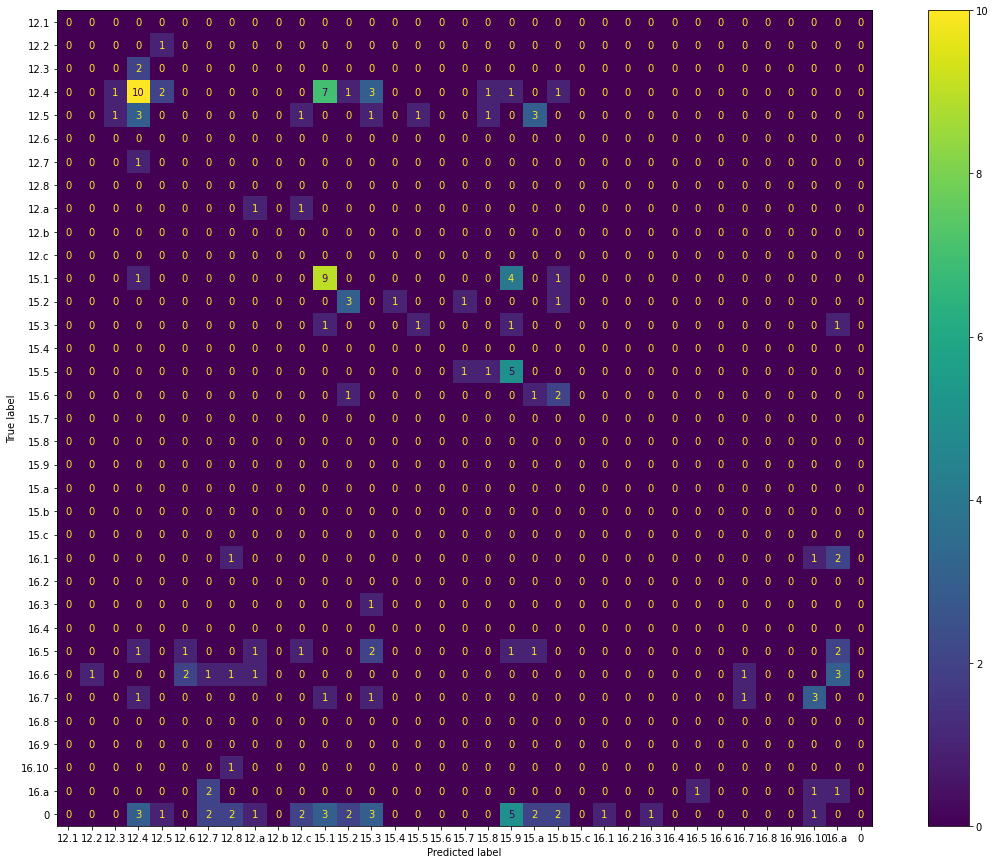

In [19]:
print(classification_report(y_true, y_pred, labels=targets))

fig, ax = plt.subplots(figsize=(20, 15))
ConfusionMatrixDisplay.from_predictions(y_true, y_pred, labels=targets, ax=ax)